In [8]:
import matplotlib.pyplot as plt, pandas as pd, seaborn as sns, transforms as T
import numpy as np
import torch.nn.functional as F
import torch, argparse, os, json
from tqdm import tqdm
from constants import *
from torch.utils.data import DataLoader
from dataset import FewShotDataset
from torch.utils.data import Subset
from model import distance, model_registry
from dataset import transforms_registry
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
log_folder = input("Log folder: ")

args = argparse.Namespace()
args_file = os.path.join(log_folder, LOGS_ARGS_FILE_NAME)
with open(args_file, "r") as f:
    args.__dict__ = json.load(f)

In [3]:
EPISODES = 10000

transforms = transforms_registry["test"](args.input_size)

selected_folders_df = pd.read_csv(SELECTED_FOLDERS_FOR_MODEL)
selected_folders = selected_folders_df[selected_folders_df["type"] == "test"]["folder"].astype(str).tolist()

dataset = FewShotDataset(FORMATTED_PHOTO_FOLDER, selected_folders, transform=transforms,
                            n_way=args.n_way, n_shot=args.n_shot, n_query=args.n_query,
                            n_episodes=EPISODES, return_class=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [4]:
model = model_registry[args.model]().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.load_state_dict(torch.load(os.path.join(log_folder, LOGS_MODEL_FILE_NAME)))
optimizer.load_state_dict(torch.load(os.path.join(log_folder, LOGS_OPTIMIZER_FILE_NAME)))

model.eval()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3516\2077922580.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(log_folder, LOG

MobileNetV3Small(
  (encoder): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2):

In [9]:
errors = {}

for support_set, query_set, classes in tqdm(dataloader, total=EPISODES):
    support_set = support_set.squeeze(0).to(device)
    query_set = query_set.squeeze(0).to(device)
    classes = classes.squeeze(0).cpu()
    
    n_class = support_set.size(0)
    n_support = support_set.size(1)
    n_query = query_set.size(1)
    
    input = torch.cat([support_set.view(n_class * n_support, *support_set.size()[2:]), 
                    query_set.view(n_class * n_query, *query_set.size()[2:])], dim=0)
    
    output = model(input)
    
    out_support = output[:n_class * n_support]
    out_query = output[n_class * n_support:]
    
    prototypes = out_support.view(n_class, n_support, -1).mean(dim=1) # Shape: [n_class, feature_dim]
    
    dists = distance(prototypes, out_query)
    
    log_p_y = F.log_softmax(-dists, dim=1).view(n_class, n_query, -1)

    _, y_hat = log_p_y.max(2)

    support_set = support_set.cpu()
    query_set = query_set.cpu()
    cols = n_class 
    rows = n_support 
    
    # get all incorrect predictions, add to errors
    for i in range(n_class):
        for j in range(n_query):
            if y_hat[i, j] != i:
                ground_truth = classes[i]
                predicted_class = classes[y_hat[i, j]]
                
                if ground_truth not in errors:
                    errors[ground_truth] = {}
                    
                if predicted_class not in errors[ground_truth]:
                    errors[ground_truth][predicted_class] = 0
                    
                errors[ground_truth][predicted_class] += 1

  3%|▎         | 284/10000 [01:22<47:04,  3.44it/s]


KeyboardInterrupt: 

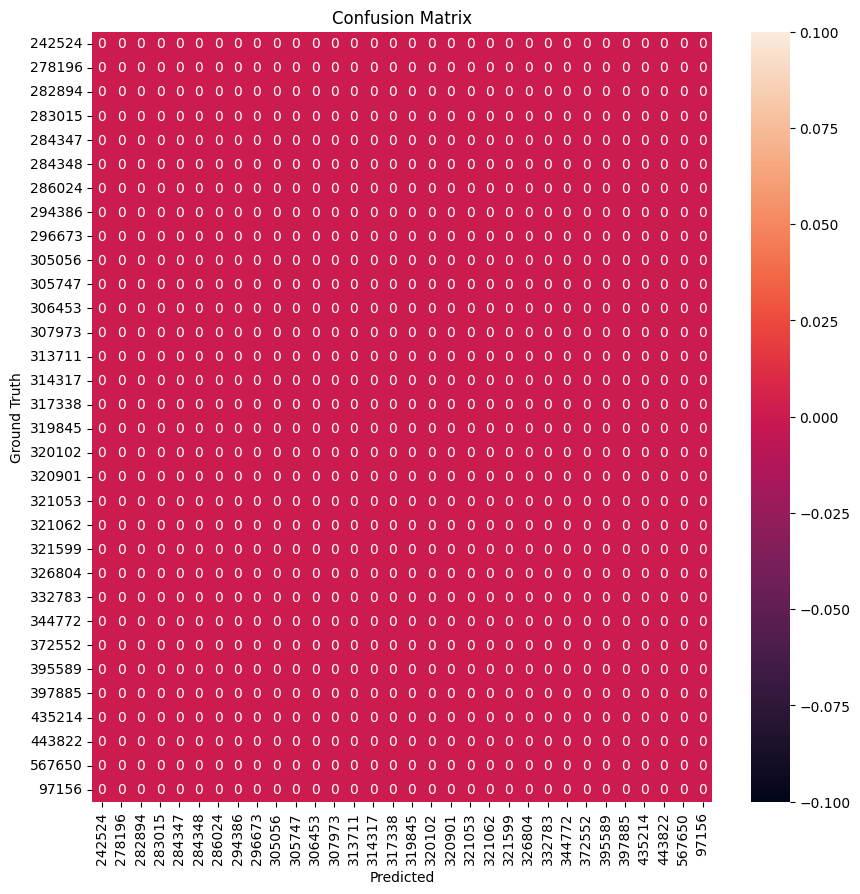

In [6]:
# create confusion matrix
confusion_matrix = np.zeros((len(selected_folders), len(selected_folders)))
for ground_truth, predicted_classes in errors.items():
    for predicted_class, count in predicted_classes.items():
        confusion_matrix[selected_folders.index(ground_truth)][selected_folders.index(predicted_class)] = count
        
# plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=selected_folders, yticklabels=selected_folders)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix")
plt.show()